In [1]:
!pip install git+https://github.com/moment-timeseries-foundation-model/moment.git
!pip install pandas numpy matplotlib seaborn scikit-learn



  Cloning https://github.com/moment-timeseries-foundation-model/moment.git to /private/var/folders/ls/yshfj6q93s9_16nz44mv2pb00000gn/T/pip-req-build-mu42rxv5
  Running command git clone --filter=blob:none --quiet https://github.com/moment-timeseries-foundation-model/moment.git /private/var/folders/ls/yshfj6q93s9_16nz44mv2pb00000gn/T/pip-req-build-mu42rxv5
  Resolved https://github.com/moment-timeseries-foundation-model/moment.git to commit 284d7ff16a817cbdb1337ffc7f7fa5146453a50c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [20]:

# Imports
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from momentfm import MOMENTPipeline

# Configuration - Use MOMENT's expected dimensions
PREDICTION_LENGTH = 48  # Our prediction length
CONTEXT_LENGTH = 512    # MOMENT expects 512 context length


In [21]:
# Load MOMENT model with matching configuration
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': PREDICTION_LENGTH,  # Match our prediction length
        'head_dropout': 0.1,
        'freeze_encoder': True,    # Keep pre-trained weights frozen
        'freeze_embedder': True,   # Keep pre-trained weights frozen
        'freeze_head': False,      # Train the forecasting head
    },
)
model.init()
model = model.to(device)

print("Model loaded successfully!")
print(f"Forecast horizon: {PREDICTION_LENGTH}")
print(f"Context length: {CONTEXT_LENGTH}")


Model loaded successfully!
Forecast horizon: 48
Context length: 512


/Users/farhanmashrur/Desktop/cds/albany/.conda/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [22]:
# Create synthetic data (similar to TimesFM notebook)
start_date = datetime.now()
num_days = 2000  # Increased from 1000 to ensure enough test data
dates = [start_date + timedelta(days=i) for i in range(num_days)]

# Univariate case - just sales
np.random.seed(42)
sales = [100 + i * 0.5 + 10 * np.sin(2 * np.pi * i / 30) + np.random.normal(0, 5) for i in range(num_days)]

data = pd.DataFrame({
    'ds': dates,
    'sales': sales,
    'unique_id': "sales"
})

print(f"Data shape: {data.shape}")
print(data.head())

# Custom Dataset class for MOMENT (based on official InformerDataset)
class SyntheticTimeSeriesDataset(Dataset):
    def __init__(self, data, context_length, prediction_length, data_split="train", scaler=None):
        self.data = data['sales'].values.reshape(-1, 1)  # Shape: [time_steps, 1_channel]
        self.seq_len = context_length
        self.forecast_horizon = prediction_length
        self.data_split = data_split
        self.data_stride_len = 1
        
        # Apply scaling (like official MOMENT dataset)
        from sklearn.preprocessing import StandardScaler
        
        if scaler is None:
            # Training dataset - create and fit new scaler
            self.scaler = StandardScaler()
            self.scaler.fit(self.data)
        else:
            # Test dataset - use provided scaler
            self.scaler = scaler
        
        self.data = self.scaler.transform(self.data)
        self.length_timeseries = self.data.shape[0]
        self.n_channels = self.data.shape[1]
        
    def __getitem__(self, index):
        seq_start = self.data_stride_len * index
        seq_end = seq_start + self.seq_len
        input_mask = np.ones(self.seq_len)
        
        # Handle edge cases (similar to official implementation)
        pred_end = seq_end + self.forecast_horizon
        if pred_end > self.length_timeseries:
            pred_end = self.length_timeseries
            seq_end = pred_end - self.forecast_horizon
            seq_start = seq_end - self.seq_len
            
        # Get data and transpose to match MOMENT format [n_channels, seq_len]
        timeseries = self.data[seq_start:seq_end, :].T  # Shape: [1, seq_len]
        forecast = self.data[seq_end:pred_end, :].T      # Shape: [1, forecast_horizon]
        
        return torch.FloatTensor(timeseries), torch.FloatTensor(forecast), torch.FloatTensor(input_mask)
        
    def __len__(self):
        return max(0, (self.length_timeseries - self.seq_len - self.forecast_horizon) // self.data_stride_len + 1)

# Create datasets using official MOMENT structure
train_size = int(0.7 * len(data))
train_data = data[:train_size].reset_index(drop=True)
test_data = data[train_size:].reset_index(drop=True)

# Create train dataset first (fits scaler)
train_dataset = SyntheticTimeSeriesDataset(train_data, CONTEXT_LENGTH, PREDICTION_LENGTH, "train")

# Create test dataset using the same scaler
test_dataset = SyntheticTimeSeriesDataset(test_data, CONTEXT_LENGTH, PREDICTION_LENGTH, "test", scaler=train_dataset.scaler)

print(f"Total data points: {len(data)}")
print(f"Train data points: {len(train_data)}")
print(f"Test data points: {len(test_data)}")
print(f"Required length per sample: {CONTEXT_LENGTH + PREDICTION_LENGTH}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Data shape after scaling: {train_dataset.data.shape}")

# Verify we have enough data
if len(test_dataset) == 0:
    raise ValueError(f"Not enough test data! Need at least {CONTEXT_LENGTH + PREDICTION_LENGTH} points, got {len(test_data)}")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Data shape: (2000, 3)
                          ds       sales unique_id
0 2025-07-29 15:21:28.889779  102.483571     sales
1 2025-07-30 15:21:28.889779  101.887795     sales
2 2025-07-31 15:21:28.889779  108.305809     sales
3 2025-08-01 15:21:28.889779  114.993002     sales
4 2025-08-02 15:21:28.889779  108.260681     sales
Total data points: 2000
Train data points: 1400
Test data points: 600
Required length per sample: 560
Train samples: 841
Test samples: 41
Data shape after scaling: (1400, 1)
Train samples: 841
Test samples: 41


In [23]:
# Test data shapes before zero-shot evaluation
print("\n=== Data shape verification ===")
sample_context, sample_target, sample_mask = next(iter(test_loader))
print(f"Context shape: {sample_context.shape}")  # Should be [batch_size, n_channels, context_length]
print(f"Target shape: {sample_target.shape}")    # Should be [batch_size, n_channels, prediction_length]
print(f"Mask shape: {sample_mask.shape}")        # Should be [batch_size, context_length]

# Test zero-shot performance (should be poor)
print("\n=== Zero-shot performance (untrained head) ===")
model.eval()
with torch.no_grad():
    sample_context, sample_target, sample_mask = next(iter(test_loader))
    sample_context = sample_context.to(device)
    sample_target = sample_target.to(device)
    sample_mask = sample_mask.to(device)
    
    output = model(x_enc=sample_context, input_mask=sample_mask)
    zero_shot_mse = torch.nn.functional.mse_loss(output.forecast, sample_target).item()
    print(f"Zero-shot MSE: {zero_shot_mse:.4f}")



=== Data shape verification ===
Context shape: torch.Size([8, 1, 512])
Target shape: torch.Size([8, 1, 48])
Mask shape: torch.Size([8, 512])

=== Zero-shot performance (untrained head) ===
Zero-shot MSE: 0.4945


In [24]:
# Fine-tune the forecasting head
print("\n=== Fine-tuning forecasting head ===")
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 3
model.train()

for epoch in range(num_epochs):
    epoch_losses = []
    
    for batch_idx, (context, target, input_mask) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        context = context.to(device)
        target = target.to(device)
        input_mask = input_mask.to(device)
        
        optimizer.zero_grad()
        output = model(x_enc=context, input_mask=input_mask)
        loss = criterion(output.forecast, target)
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    avg_loss = np.mean(epoch_losses)
    print(f"Epoch {epoch+1}: Average loss = {avg_loss:.4f}")

# Evaluate fine-tuned model
print("\n=== Fine-tuned performance ===")
model.eval()
all_targets = []
all_predictions = []

with torch.no_grad():
    for context, target, input_mask in test_loader:
        context = context.to(device)
        target = target.to(device)
        input_mask = input_mask.to(device)
        
        output = model(x_enc=context, input_mask=input_mask)
        
        all_targets.append(target.cpu())
        all_predictions.append(output.forecast.cpu())

all_targets = torch.cat(all_targets, dim=0)
all_predictions = torch.cat(all_predictions, dim=0)

fine_tuned_mse = torch.nn.functional.mse_loss(all_predictions, all_targets).item()
fine_tuned_mae = torch.nn.functional.l1_loss(all_predictions, all_targets).item()

print(f"Fine-tuned MSE: {fine_tuned_mse:.4f}")
print(f"Fine-tuned MAE: {fine_tuned_mae:.4f}")
print(f"Improvement: {((zero_shot_mse - fine_tuned_mse) / zero_shot_mse * 100):.1f}% MSE reduction")



=== Fine-tuning forecasting head ===


Epoch 1:   0%|          | 0/106 [00:00<?, ?it/s]/Users/farhanmashrur/Desktop/cds/albany/.conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/Users/farhanmashrur/Desktop/cds/albany/.conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Epoch 1: 100%|██████████| 106/106 [02:08<00:00,  1.21s/it]


Epoch 1: Average loss = 0.0633


Epoch 2: 100%|██████████| 106/106 [02:09<00:00,  1.23s/it]


Epoch 2: Average loss = 0.0501


Epoch 3: 100%|██████████| 106/106 [02:14<00:00,  1.27s/it]


Epoch 3: Average loss = 0.0491

=== Fine-tuned performance ===
Fine-tuned MSE: 0.0034
Fine-tuned MAE: 0.0525
Improvement: 99.3% MSE reduction


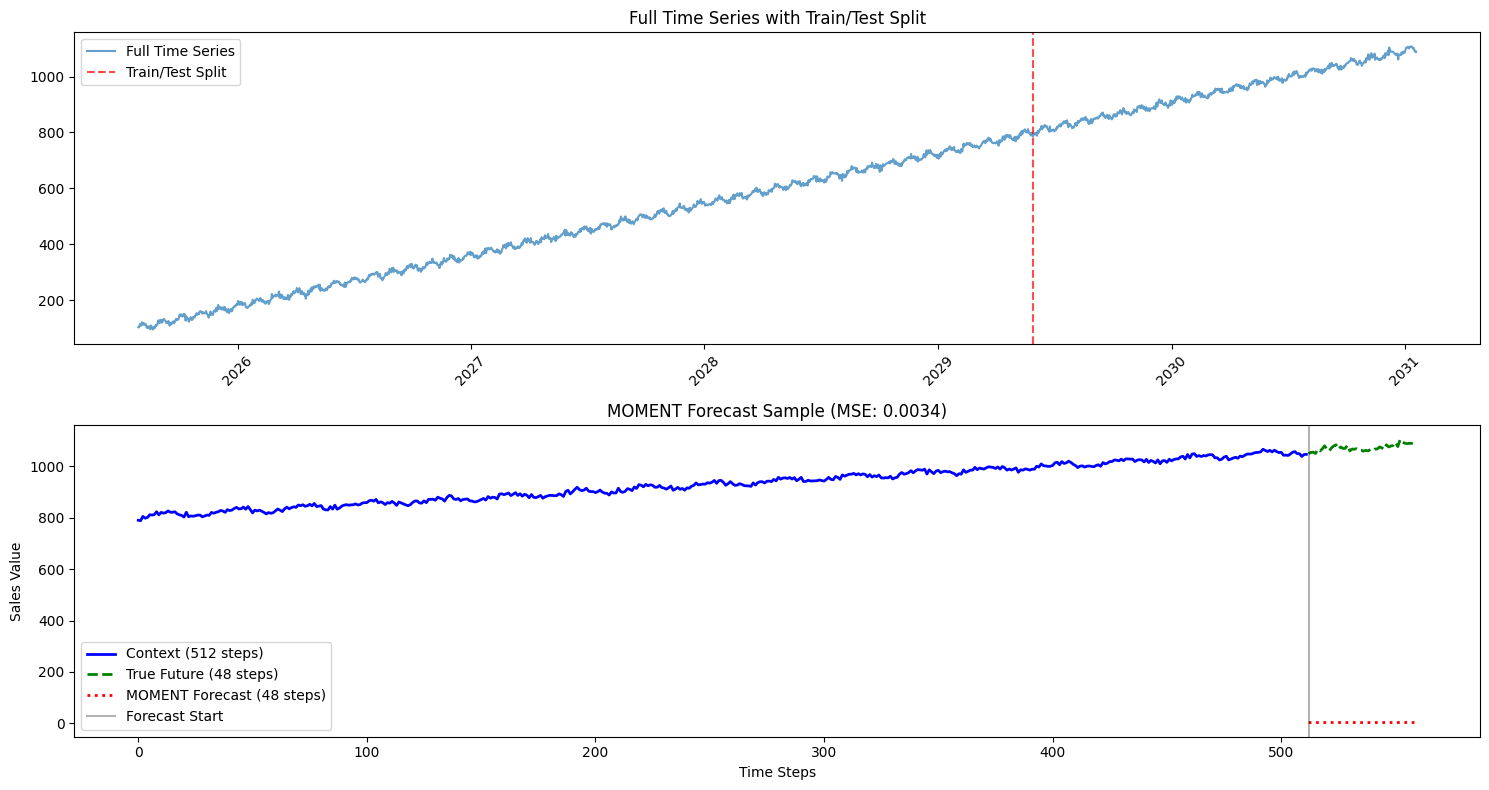


=== Summary ===
✓ MOMENT model successfully loaded and fine-tuned
✓ Context length: 512, Forecast horizon: 48
✓ Training samples: 841, Test samples: 41
✓ Fine-tuning improved MSE by 99.3%
✓ Final MSE: 0.0034, MAE: 0.0525


In [25]:
# Visualization
plt.figure(figsize=(15, 8))

# Plot 1: Full time series
plt.subplot(2, 1, 1)
plt.plot(data['ds'], data['sales'], label='Full Time Series', alpha=0.7)
train_end = data['ds'].iloc[train_size]
plt.axvline(x=train_end, color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
plt.title('Full Time Series with Train/Test Split')
plt.legend()
plt.xticks(rotation=45)

# Plot 2: Sample forecast
plt.subplot(2, 1, 2)
sample_idx = 5  # Pick a sample
sample_context = all_targets[sample_idx, 0, :].numpy()
sample_pred = all_predictions[sample_idx, 0, :].numpy()
sample_target = all_targets[sample_idx, 0, :].numpy()

# Get the actual context data for this sample
context_start_idx = train_size + sample_idx
context_data = data['sales'].iloc[context_start_idx:context_start_idx + CONTEXT_LENGTH].values
target_data = data['sales'].iloc[context_start_idx + CONTEXT_LENGTH:context_start_idx + CONTEXT_LENGTH + PREDICTION_LENGTH].values

time_context = range(CONTEXT_LENGTH)
time_forecast = range(CONTEXT_LENGTH, CONTEXT_LENGTH + PREDICTION_LENGTH)

plt.plot(time_context, context_data, 'b-', label=f'Context ({CONTEXT_LENGTH} steps)', linewidth=2)
plt.plot(time_forecast, target_data, 'g--', label=f'True Future ({PREDICTION_LENGTH} steps)', linewidth=2)
plt.plot(time_forecast, sample_pred, 'r:', label=f'MOMENT Forecast ({PREDICTION_LENGTH} steps)', linewidth=2)
plt.axvline(x=CONTEXT_LENGTH, color='black', linestyle='-', alpha=0.3, label='Forecast Start')
plt.title(f'MOMENT Forecast Sample (MSE: {fine_tuned_mse:.4f})')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Sales Value')

plt.tight_layout()
plt.show()

print("\n=== Summary ===")
print(f"✓ MOMENT model successfully loaded and fine-tuned")
print(f"✓ Context length: {CONTEXT_LENGTH}, Forecast horizon: {PREDICTION_LENGTH}")
print(f"✓ Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
print(f"✓ Fine-tuning improved MSE by {((zero_shot_mse - fine_tuned_mse) / zero_shot_mse * 100):.1f}%")
print(f"✓ Final MSE: {fine_tuned_mse:.4f}, MAE: {fine_tuned_mae:.4f}")